# Alpha-angle classification

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd

from data import Data
from dataset import Dataset
from clusterizer import Clusterizer
from trainer import Trainer

In [2]:
data = Data()

Files reading...
File: training_30


100%|██████████| 834867/834867 [01:02<00:00, 13296.60it/s]


File: training_50


  0%|          | 12/21741 [00:00<03:16, 110.73it/s]

Targets calculating...


100%|██████████| 21741/21741 [04:06<00:00, 88.28it/s] 


Data size: 21741


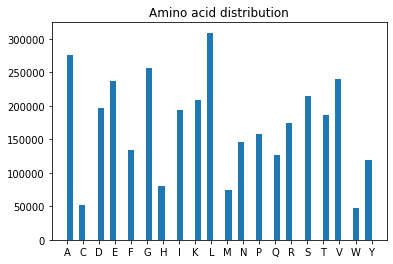

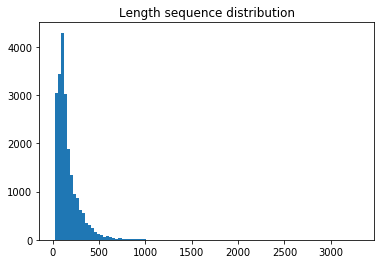

In [3]:
print('Data size:', len(data.seqs))

plt.hist(sorted([a for aa in data.seqs for a in aa]), bins=50);
plt.title('Amino acid distribution')
plt.show()

plt.hist([len(aa) for aa in data.seqs], bins=100);
plt.title('Length sequence distribution')
plt.show()

In [4]:
dataset = Dataset(data, 220, len_subseq=32)

100%|██████████| 21741/21741 [00:11<00:00, 1959.35it/s]


Train dataset size with subsequence length of 32: 39780


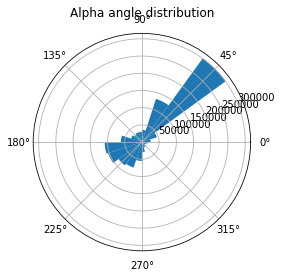

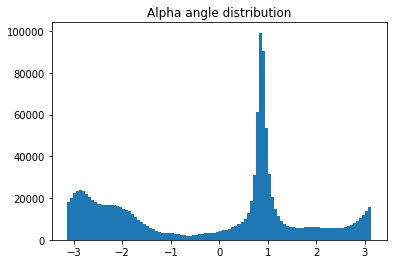

In [5]:
train_dataset = dataset.train_data_features

print('Train dataset size with subsequence length of 32:', len(train_dataset[0]))

train_alphas = np.array([a for aa in train_dataset[2] for a in aa])

plt.subplot(111, polar=True).hist(train_alphas, bins=20);
plt.title('Alpha angle distribution')
plt.show()

plt.hist(train_alphas, bins=100);
plt.title('Alpha angle distribution')
plt.show()

# 2-class classification

In [6]:
clusterizer_2 = Clusterizer(dataset, n_clusters=2)

Class 0: 595789 elements
Class 1: 637391 elements


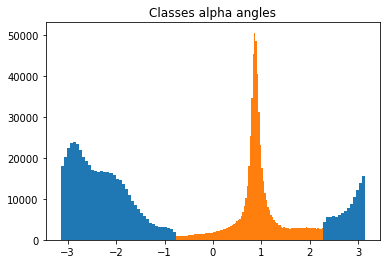

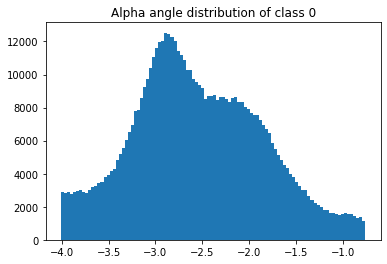

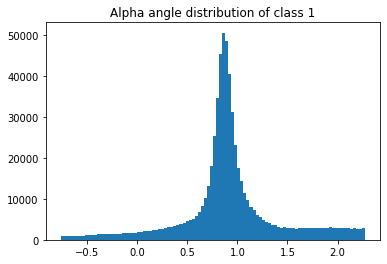

In [7]:
print('Class 0: %d elements' % clusterizer_2.angle_class_idxs[0].sum())
print('Class 1: %d elements' % clusterizer_2.angle_class_idxs[1].sum())


plt.hist(clusterizer_2.angle_class[0], bins=100);
plt.hist(clusterizer_2.angle_class[1], bins=100);
plt.title('Classes alpha angles')
plt.show()
    
plt.hist(np.append(clusterizer_2.angle_class[0][clusterizer_2.angle_class[0] < 0],
                   clusterizer_2.angle_class[0][clusterizer_2.angle_class[0] > 0] - 2 * np.pi), bins=100);
plt.title('Alpha angle distribution of class 0')
plt.show()

plt.hist(clusterizer_2.angle_class[1], bins=100);
plt.title('Alpha angle distribution of class 1')
plt.show()

## Experiments

In [9]:
from models.Conv1d import Conv1d
from models.Conv1d_BiLSTM import Conv1d_BiLSTM
from models.Conv1d_BiLSTM_Conv2d import Conv1d_BiLSTM_Conv2d
from models.Conv1d_Conv2d import Conv1d_Conv2d
from models.BiLSTM import BiLSTM
from models.BiLSTM_Conv2d import BiLSTM_Conv2d
from models.Conv2d import Conv2d
from models.UConv1d import UConv1d
from models.UConv1d_BiLSTM import UConv1d_BiLSTM
from models.UConv1d_BiLSTM_Conv2d import UConv1d_BiLSTM_Conv2d


models = ['Conv1d', 'Conv1d_BiLSTM', 'Conv1d_BiLSTM_Conv2d', 'Conv1d_Conv2d', 'BiLSTM',
          'BiLSTM_Conv2d', 'Conv2d', 'UConv1d', 'UConv1d_BiLSTM', 'UConv1d_BiLSTM_Conv2d']

trainers_2class = {}

### Model Conv1d

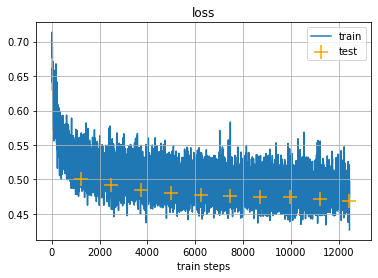

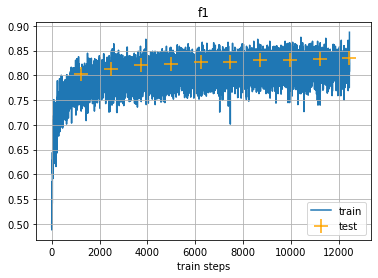

Epoch: 10, val loss: 0.4691169340502132, val f1: 0.8357517482517484


In [10]:
model = Conv1d(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['Conv1d'] = trainer

### Model Conv1d_BiLSTM

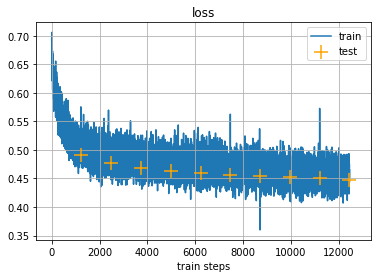

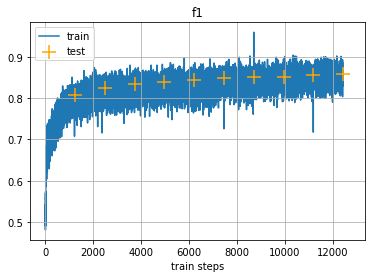

Epoch: 10, val loss: 0.4473329097032547, val f1: 0.8584215683510039


In [12]:
model = Conv1d_BiLSTM(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['Conv1d_BiLSTM'] = trainer

### Model Conv1d_BiLSTM_Conv2d

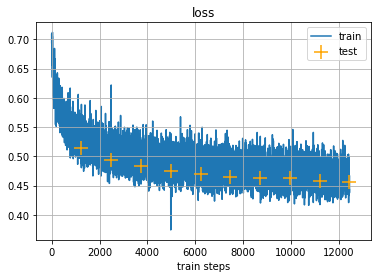

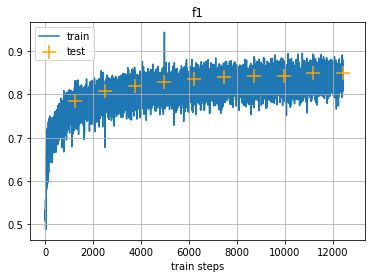

Epoch: 10, val loss: 0.4554924733259461, val f1: 0.8502361549740581


In [13]:
model = Conv1d_BiLSTM_Conv2d(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['Conv1d_BiLSTM_Conv2d'] = trainer

### Model Conv1d_Conv2d

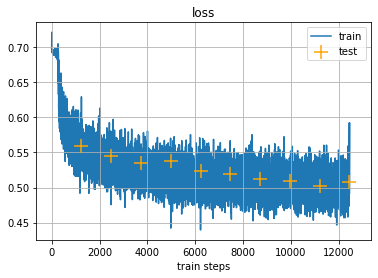

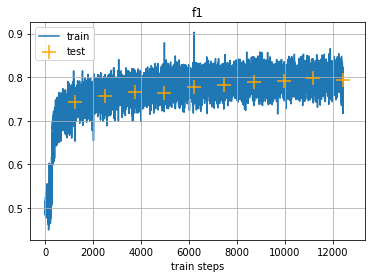

Epoch: 10, val loss: 0.5076737195253372, val f1: 0.7945730177080983


In [14]:
model = Conv1d_Conv2d(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['Conv1d_Conv2d'] = trainer

### Model BiLSTM

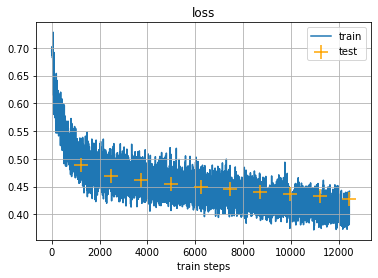

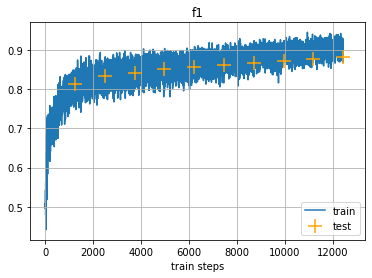

Epoch: 10, val loss: 0.427890421314673, val f1: 0.8819133487480263


In [15]:
model = BiLSTM(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['BiLSTM'] = trainer

### Model BiLSTM_Conv2d

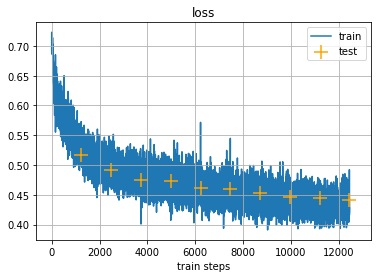

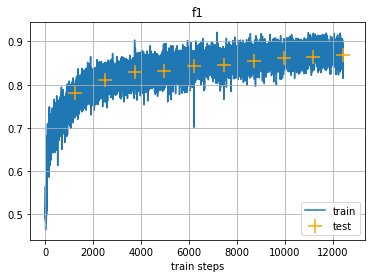

Epoch: 10, val loss: 0.44066698795015163, val f1: 0.8686054872546808


In [18]:
model = BiLSTM_Conv2d(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['BiLSTM_Conv2d'] = trainer

### Model Conv2d

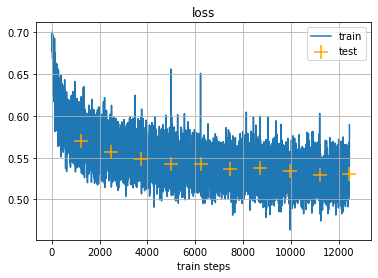

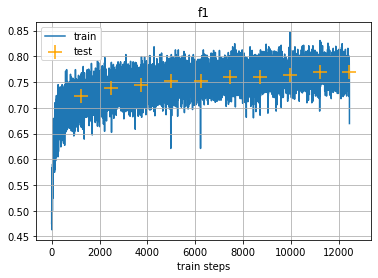

Epoch: 10, val loss: 0.530320625684478, val f1: 0.7687605741033162


In [19]:
model = Conv2d(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['Conv2d'] = trainer

### Model UConv1d

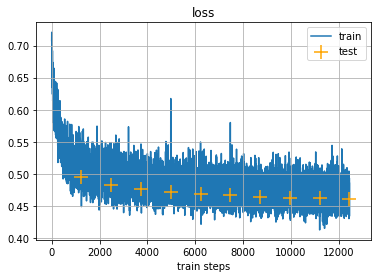

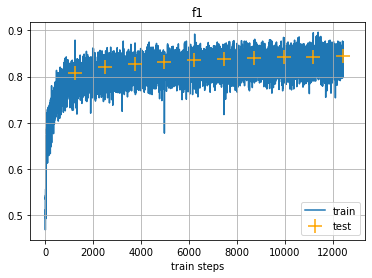

Epoch: 10, val loss: 0.46046269888227637, val f1: 0.8444517679900744


In [20]:
model = UConv1d(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['UConv1d'] = trainer

### Model UConv1d_BiLSTM

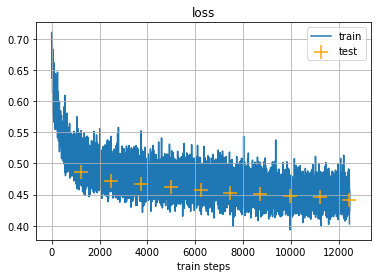

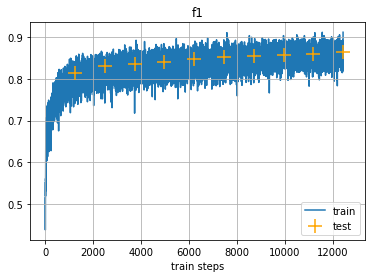

Epoch: 10, val loss: 0.4420139400796457, val f1: 0.8646271571170765


In [21]:
model = UConv1d_BiLSTM(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['UConv1d_BiLSTM'] = trainer

### Model UConv1d_BiLSTM_Conv2d

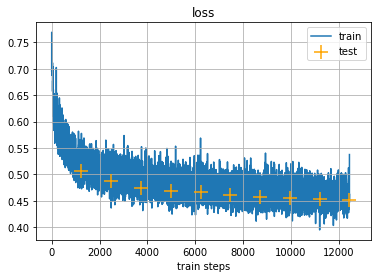

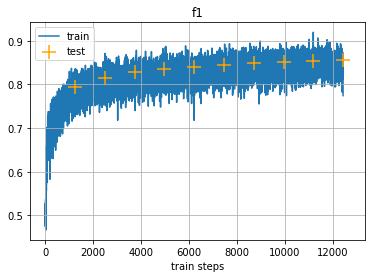

Epoch: 10, val loss: 0.4510665649717504, val f1: 0.855934186780961


In [22]:
model = UConv1d_BiLSTM_Conv2d(len_subseq=dataset.len_subseq, n_class=2)

trainer = Trainer(model, dataset, clusterizer_2)
trainer.train(n_epochs=10)

trainers_2class['UConv1d_BiLSTM_Conv2d'] = trainer

## Results

In [36]:
from sklearn.metrics import f1_score

def compute_scores(trainers):
    scores = []
    for m, t in trainers.items():
        scores.append(f1_score(t.targs, torch.argmax(t.preds, dim=-1)))
    return scores

In [44]:
scores_2class = compute_scores(trainers_2class)

result_2class = pd.DataFrame(data=scores_2class, index=models, columns=['F1 score'])
result_2class.index.name = 'Model'

display(result_2class.sort_values(by='F1 score', ascending=False))

,F1 score
Model,
BiLSTM,0.881808
BiLSTM_Conv2d,0.868541
UConv1d_BiLSTM,0.864026
UConv1d_BiLSTM_Conv2d,0.856585
Conv1d_BiLSTM,0.856094
Conv1d_BiLSTM_Conv2d,0.850337
UConv1d,0.842637
Conv1d,0.833162
Conv1d_Conv2d,0.798300
